In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from IPython.display import HTML
from ipywidgets import interact, interactive, FloatSlider, IntSlider, Checkbox

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

# global gyromagnetic ratio value in [Hz/T]
gammaBar = 42.58e06

# $T_2$ and $T_2^*$ Decay

$T_1$ and $T_2$ describe the rate at which longitudinal magnetization recovers, and the rate at which transverse magnetization decays, respectively. These are fundamental properties of the magnetization within each voxel.

Imperfections in the static magnetic field $B_0$ corrupt the apparent $T_2$ in each pixel. This is because ***phase is accumulating within each voxel*** and causing signal loss.

Let's watch what happens to the transverse magnetization ***within a single voxel/pixel*** as we change the voxel size, strength of the gradient, and $T_2$.

In [2]:
# number of sub-voxel locations
nsub = 100

def plotDecayFromIntraVoxelGradient(voxelSize_mm, gradientThroughVoxel_mT_m, T2_ms):

    # total time interval (i.e., echo time)
    T = 0.2
    dt = 2e-4
    ntime = int(T/dt)
    tvec = np.arange(0,ntime)*dt

    T2_sec = T2_ms * 1e-3

    # number of sub-voxel locations
    nsub = 200

    # array of sub-voxel spatial coordinates [m]
    r = np.arange(0,nsub) * (voxelSize_mm * 1e-3 / nsub)

    # convert to frequency [rad/s]
    omega = gammaBar * 2.0 * np.pi * gradientThroughVoxel_mT_m * 1e-3 * r

    # phase accumulated per time step
    phi = omega * dt

    # pre-calculate rotation matrices
    R = np.zeros((2,2,nsub), dtype=np.float32)
    for n in range(nsub):
        R[0,0,n] = np.cos(phi[n])
        R[0,1,n] = -np.sin(phi[n])
        R[1,0,n] = np.sin(phi[n])
        R[1,1,n] = np.cos(phi[n])

    # initialize the magnetization within the voxel assuming it is real valued
    # immediately after an RF excitation
    M = np.zeros((2,nsub),dtype=np.float32)
    M[0,:] = 1.0

    # allocate signal at each time step
    sig = np.zeros((ntime,), dtype=np.complex64)

    # calculate the signal at each time step
    for i in range(ntime):

        # signal at current time step
        tsig = np.zeros((nsub,), dtype=np.complex64)

        # loop over sub-voxel locations and apply rotation due to gradient
        # and apply T2 decay
        for n in range(nsub):
            M[:,n] = (R[:,:,n] @ M[:,n]) * np.exp(-dt / T2_sec)

        # signal at current time point
        sig[i] = np.sum(M[0,:] + 1j*M[1,:])/nsub


    # make the figure
    fig,ax = plt.subplots()
    l1, = ax.plot(tvec, np.real(sig), label='Real')
    l2, = ax.plot(tvec, np.imag(sig), label='Imag')
    l3, = ax.plot(tvec, np.abs(sig), label='Abs')
    l4, = ax.plot(tvec, np.exp(-tvec/T2_sec), label='Pure $T_2$')
    plt.grid()
    plt.ylabel('Signal')
    plt.xlabel('Time [s]')
    ax.legend(handles=[l1, l2, l3, l4])
    plt.show()


w = interactive(plotDecayFromIntraVoxelGradient,
                voxelSize_mm=FloatSlider(min=1.0, max=4.0, value=2.0, description='Voxel Size [mm]', continuous_update=False),
                gradientThroughVoxel_mT_m=FloatSlider(min=-0.125, max=0.125, value=0.0, step=0.005, description='G [mT/m]', continuous_update=False),
                T2_ms=FloatSlider(min=20.0, max=80.0, value=40.0, description='T2 [ms]', continuous_update=False))
display(w)

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='Voxel Size [mm]', max=4.0, …

As you can see above, errors in the magnetic field *within a voxel* will always shorten the apparent $T_2$. The effective $T_2$ is known as $T_2^*$. If the green line above can be approximated with as $e^{-t/T_2^*}$, then the relationship between $T_2$, $T_2^*$, and the signal decay attributed only to the field inhomogeneities ($T_2^\prime$) is given by the following:

$\frac{1}{T_2^*} = \frac{1}{T_2} + \frac{1}{T_2^\prime}$

# Nuclear Magnetic Resonance Spin Echoes

Spin echoes have the goal of eliminating the effects of $T_2^\prime$, and allowing us to measure a purely $T_2$-weighted signal. This is done by using RF pulses to reverse the phase spins within a voxel, therefore allowing them to *rephase* instead of continuing to *dephase*. Let's see what this looks like:

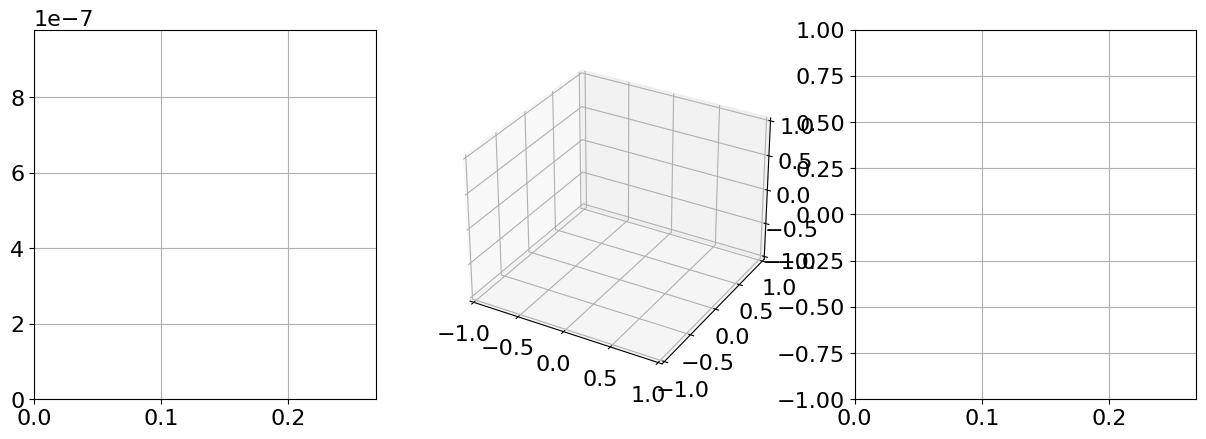

<ipython-input-6-979b0651eed4>:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 256)


In [6]:
# discrete time step for simulation
dt = 4e-4

# duration of an RF pulse
trf = 15e-3
nrf = int(trf/dt)

# calculate amplitude of RF pulses to achieve 90-degree and 180-degree flip angles
a90 = 0.5 * np.pi / (2.0 * np.pi * gammaBar * trf)
a180 = 2.0 * a90

# define transverse relaxation time constant
T2 = 0.08

# define an intravoxel gradient
gradientThroughVoxel_mT_m = 0.13
G = gradientThroughVoxel_mT_m * 1e-3

# echo time
TE = 0.075

# total simulation time
T = 3*T2

# make the RF pulse sequence
rf90 = a90 * np.ones((nrf,), dtype=np.float32)
a90 = rf90[0]
rf180 = a180 * np.ones((nrf,), dtype=np.float32)
a180 = rf180[0]
wait1 = np.zeros((int(0.5*TE/dt),), dtype=np.float32)
wait2 = np.zeros((int((T-0.5*TE)/dt),), dtype=np.float32)
rf = np.concatenate([rf90, wait1, rf180, wait2], axis=0)

# time vector
tvec = np.arange(0,rf.size) * dt

# sub-voxel spatial locations
nsub = 200
voxelSize = 0.003
r = np.arange(0,nsub) * voxelSize / nsub


# initialize signal
sig = np.zeros((tvec.size,), dtype=np.complex64)

# calculate rotation matrices at each time step and spatial location
R = np.zeros((3,3,tvec.size,r.size),dtype=np.float32)
for nt in range(tvec.size):
    for nr in range(r.size):

        if rf[nt] > 0.0:
            phi = 2.0 * np.pi * gammaBar * rf[nt] * dt
            Rxy = np.zeros((3,3), dtype=np.float32)
            Rxy[0,0] = 1.0
            Rxy[1,1] = np.cos(phi)
            Rxy[1,2] = -np.sin(phi)
            Rxy[2,1] = np.sin(phi)
            Rxy[2,2] = np.cos(phi)

            Rz = np.eye(3)
        else:
            Rxy = np.eye(3)

            phi = 2.0 * np.pi * gammaBar * G * r[nr] * dt
            Rz = np.zeros((3,3), dtype=np.float32)
            Rz[0,0] = np.cos(phi)
            Rz[0,1] = -np.sin(phi)
            Rz[1,0] = np.sin(phi)
            Rz[1,1] = np.cos(phi)
            Rz[2,2] = 1.0

        R[:,:,nt,nr] = Rz @ Rxy


fig = plt.figure()
fig.set_figwidth(15.0)
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133)

ax1.set_xlim(0.0, tvec[-1])
ax1.set_ylim(0.0, 1.25*a180)
ax1.grid()

ax2.set_xlim(-1.0, 1.0)
ax2.set_ylim(-1.0, 1.0)
ax2.set_zlim(-1.0, 1.0)
ax2.grid()

ax3.set_xlim(0.0, tvec[-1])
ax3.set_ylim(-1.0, 1.0)
ax3.grid()

plt.show()



viridis = cm.get_cmap('viridis', 256)

# intialize line objects
line = []
tmp, = ax1.plot([], [])
line.append(tmp) # rf plot vs time
for n in range(r.size):     # plot for each isochromat
    tmp, = ax2.plot3D([], [], [], linewidth=1, color=viridis(n/r.size))
    line.append(tmp)
tmp, = ax3.plot([], [])
line.append(tmp) # real part
tmp, = ax3.plot([], [])
line.append(tmp) # imag part
tmp, = ax3.plot([], [])
line.append(tmp) # abs part
tmp, = ax3.plot([], [])
line.append(tmp) # pure T2 part


def frame(idx):

    #ax1.clear()
    #ax2.clear()
    #ax3.clear()

    line_idx = 0

    xdata = tvec[:(idx+1)]
    ydata = rf[:(idx+1)]
    line[line_idx].set_data(xdata, ydata)
    line_idx += 1


    # simulate magnetization at current point
    M = np.zeros((3,nsub), dtype=np.float32)
    M[2,:] = 1.0
    for nt in range(idx+1):
        for nr in range(r.size):
            M[:,nr] = R[:,:,nt,nr] @ M[:,nr]
        M[0,:] = M[0,:] * np.exp(-dt/T2)
        M[1,:] = M[1,:] * np.exp(-dt/T2)

    # plot magnetization
    for n in range(r.size):
        xdata = [0.0, M[0,n]]
        ydata = [0.0, M[1,n]]
        zdata = [0.0, M[2,n]]
        line[line_idx].set_data(xdata, ydata)
        line[line_idx].set_3d_properties(zdata)
        line_idx += 1

    # calculate signal at current step
    sig[idx] = np.sum(M[0,:] + 1j*M[1,:]) / r.size

    # plot real signal
    xdata = tvec[:(idx+1)]
    ydata = np.real(sig[:(idx+1)])
    line[line_idx].set_data(xdata, ydata)
    line_idx += 1

    # plot imaginary signal
    xdata = tvec[:(idx+1)]
    ydata = np.imag(sig[:(idx+1)])
    line[line_idx].set_data(xdata, ydata)
    line_idx += 1

    # plot magnitude signal
    xdata = tvec[:(idx+1)]
    ydata = np.abs(sig[:(idx+1)])
    line[line_idx].set_data(xdata, ydata)
    line_idx += 1

    # plot pure T2 signal
    if idx >= nrf:
        xdata = tvec[nrf:(idx+1)]
        ydata = np.exp(-(xdata-trf) / T2)
    line[line_idx].set_data(xdata, ydata)

    #idx = idx + 1

    return line

anim = animation.FuncAnimation(fig, frame, frames=tvec.size, blit=False, repeat=True)
plt.show()

anim.save('SpinEcho_90x_180x.gif', writer = "pillow", fps=50 )
HTML(anim.to_html5_video())



Applying a second RF pulse flipped the phase of the transverse magnetization and the spins then began to re-align with one another, eventually lining back up with the $T_2$ decay curve at the echo time TE.

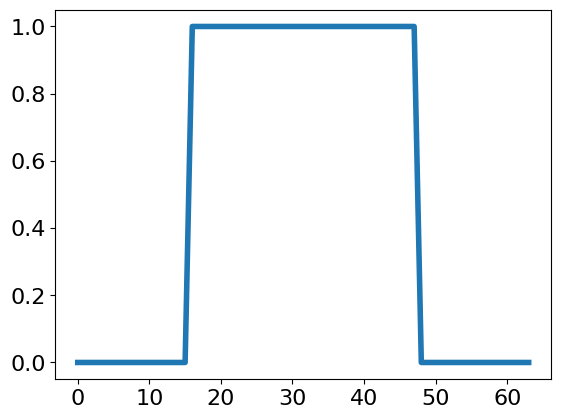

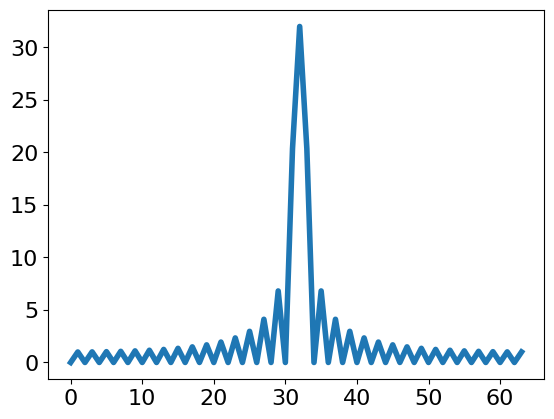

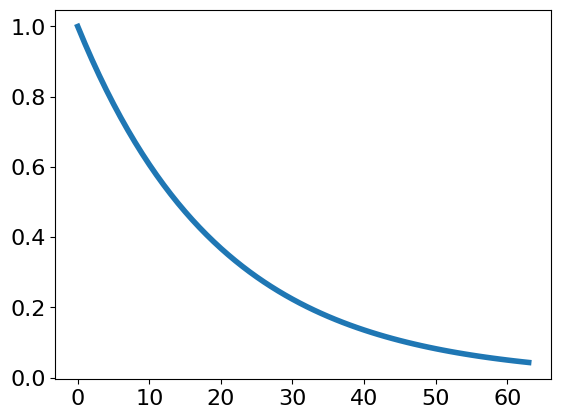

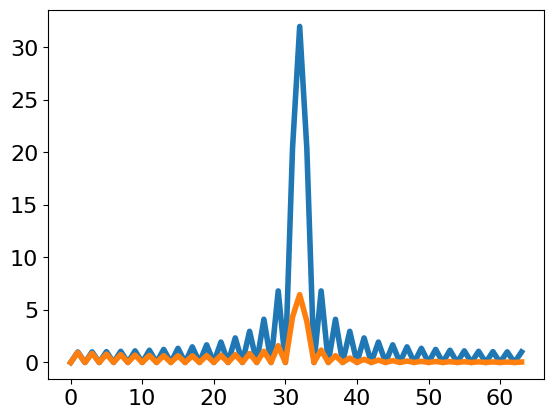

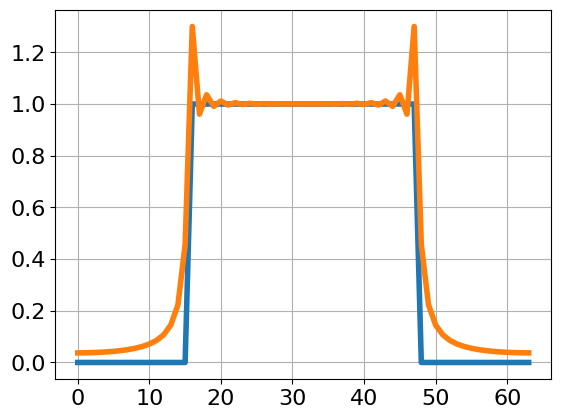

In [4]:
T2 = 80e-3
N = 64 # matrix size along the phase encoding direction
ETL = N # echo train length
ESP = 4e-3

obj = np.zeros((N,), dtype=np.float32)
obj[32-16:32+16] = 1.0

plt.figure()
plt.plot(obj)
plt.show()


ks = np.fft.fftshift(np.fft.fft(np.fft.fftshift(obj)))
plt.figure()
plt.plot(np.abs(ks))
plt.show()

n = np.arange(0,ETL)
filt = np.exp(-n*ESP / T2)
plt.figure()
plt.plot(filt)
plt.show()

fks = filt * ks
plt.figure()
plt.plot(np.abs(ks))
plt.plot(np.abs(fks))
plt.show()

img = np.abs(np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(fks))))
img = img / img[32]
plt.figure()
plt.plot(obj)
plt.plot(img)
plt.grid()
plt.show()

# Interactive Phase Graphs

In [32]:

def plotThreePulsePhaseGraph(fa1, fa2, fa3, tau12, tau23):
    #   fa1 - flip angle of RF pulse 1 [deg]
    #   fa2 - flip angle of RF pulse 2 [deg]
    #   fa3 - flip angle of RF pulse 3 [deg]
    #   tau12 - time between first and second RF pulses [ms]
    #   tau23 - time between second and third RF pulses [ms]

    tau_post = tau12 + tau23*2

    a1 = fa1 * np.pi / 180.0
    a2 = fa2 * np.pi / 180.0
    a3 = fa3 * np.pi / 180.0

    # keep track of all start/end phases, times, and magnetization
    nseg = 20
    p1 = np.zeros((nseg,),dtype=np.float32) # phase at start of segment
    p2 = np.zeros((nseg,),dtype=np.float32) # phase at end of segment
    t1 = np.zeros((nseg,),dtype=np.float32) # time at beginning of segment
    t2 = np.zeros((nseg,),dtype=np.float32) # time at end of segment
    m = np.zeros((nseg,),dtype=np.complex64)
    echoAtTime = [None] * nseg
    isMz = [False] * nseg

    #------------#
    # RF Pulse 1 #
    #------------#

    # segment 0: FID from first RF pulse
    p1[0] = 0.0
    p2[0] = tau12
    t1[0] = 0.0
    t2[0] = tau12
    m[0] = np.sin(a1)

    # segment 1: fresh longitudinal magnetization
    p1[1] = 0.0
    p2[1] = 0.0
    t1[1] = 0.0
    t2[1] = tau12
    m[1] = np.cos(a1)
    isMz[1] = True

    # segment 2: FID from segment 0 continues to dephase
    p1[2] = p2[0]
    p2[2] = p1[2] + tau23
    t1[2] = tau12
    t2[2] = tau12 + tau23
    m[2] = np.sin(a1) * np.cos(a2/2) * np.cos(a2/2)

    # segment 3: flip back of magnetization from segment 0 to z axis
    p1[3] = p2[0]
    p2[3] = p2[0]
    t1[3] = tau12
    t2[3] = tau12 + tau23
    m[3] = np.sin(a1) * np.sin(a2)
    isMz[3] = True

    # segment 4: new FID from second RF pulse acting on fresh Mz
    p1[4] = 0.0
    p2[4] = tau23
    t1[4] = tau12
    t2[4] = tau12 + tau23
    m[4] = np.cos(a1) * np.sin(a2)

    # segment 5: fresh longitudinal magnetization remaining after second RF
    p1[5] = 0.0
    p2[5] = 0.0
    t1[5] = tau12
    t2[5] = tau12 + tau23
    m[5] = np.cos(a1) * np.cos(a2)
    isMz[5] = True

    # segment 6: refocusing of magnetization from segment 0
    p1[6] = -p2[0]
    p2[6] = p1[6] + tau23
    t1[6] = tau12
    t2[6] = tau12 + tau23
    m[6] = np.sin(a1) * np.sin(a2/2) * np.sin(a2/2)
    echoAtTime[6] = 2*tau12

    # segment 7: segment 2 continues to dephase after RF 3
    p1[7] = p2[2]
    p2[7] = p1[7] + tau_post
    t1[7] = tau12 + tau23
    t2[7] = tau12 + tau23 + tau_post
    m[7] = np.sin(a1) * np.cos(a2/2) * np.cos(a2/2) * np.cos(a3/2) * np.cos(a3/2)

    # segment 8: segment 4 continues to dephase after RF 3
    p1[8] = p2[4]
    p2[8] = p1[8] + tau_post
    t1[8] = tau12 + tau23
    t2[8] = tau12 + tau23 + tau_post
    m[8] = np.cos(a1) * np.sin(a2) * np.cos(a3/2) * np.cos(a3/2)

    # segment 9: segment 6 continues to dephase after RF 3
    p1[9] = p2[6]
    p2[9] = p1[9] + tau_post
    t1[9] = tau12 + tau23
    t2[9] = tau12 + tau23 + tau_post
    m[9] = np.sin(a1) * np.sin(a2/2) * np.sin(a2/2) * np.cos(a3/2) * np.cos(a3/2)

    # segment 10: FID of remaining fresh longitudinal magnetization from RF 3
    p1[10] = 0.0
    p2[10] = tau_post
    t1[10] = tau12 + tau23
    t2[10] = tau12 + tau23 + tau_post
    m[10] = np.cos(a1) * np.cos(a2) * np.sin(a3)

    # segment 11: refocusing of segment 6 via RF 3
    p1[11] = -p2[6]
    p2[11] = p1[11] + tau_post
    t1[11] = tau12 + tau23
    t2[11] = tau12 + tau23 + tau_post
    m[11] = np.sin(a1) * np.sin(a2/2) * np.sin(a2/2) * np.sin(a3/2) * np.sin(a3/2)
    echoAtTime[11] = 2*tau23

    # segment 12: RF 3 flipping portion of segment 2 back along longitudinal axis
    p1[12] = p2[2]
    p2[12] = p1[12]
    t1[12] = tau12 + tau23
    t2[12] = tau12 + tau23 + tau_post
    m[12] = np.sin(a1) * np.cos(a2/2) * np.cos(a2/2) * np.sin(a3)
    isMz[12] = True

    # segment 13: stimulated echo (tipping into transverse plane and refocusing the longitudinal magnetization in segment 3)
    p1[13] = -p2[3]
    p2[13] = p1[13] + tau_post
    t1[13] = tau12 + tau23
    t2[13] = tau12 + tau23 + tau_post
    m[13] = np.sin(a1) * np.sin(a2) * np.sin(a3)
    echoAtTime[13] = tau23 + 2*tau12

    # segment 14: refocusing of segment 4 via RF 3
    p1[14] = -p2[4]
    p2[14] = p1[14] + tau_post
    t1[14] = tau12 + tau23
    t2[14] = tau12 + tau23 + tau_post
    m[14] = np.cos(a1) * np.sin(a2) * np.sin(a3/2) * np.sin(a3/2)
    echoAtTime[14] = tau12 + 2*tau23

    # segment 15: flipping part of segment 4 back onto longitudinal axis via RF 3
    p1[15] = p2[4]
    p2[15] = p1[15]
    t1[15] = tau12 + tau23
    t2[15] = tau12 + tau23 + tau_post
    m[15] = np.cos(a1) * np.sin(a2) * np.sin(a3)
    isMz[15] = True

    # segment 16: refocusing of segment 2 via RF 3
    p1[16] = -p2[2]
    p2[16] = p1[16] + tau_post
    t1[16] = tau12 + tau23
    t2[16] = tau12 + tau23 + tau_post
    m[16] = np.sin(a1) * np.cos(a2/2) * np.cos(a2/2) * np.sin(a3/2) * np.sin(a3/2)
    echoAtTime[16] = 2*(tau12 + tau23)

    # segment 17: flipping back magnetization from segment 6 along longitudinal axis via RF 3
    p1[17] = p2[6]
    p2[17] = p1[17]
    t1[17] = tau12 + tau23
    t2[17] = tau12 + tau23 + tau_post
    m[17] = np.sin(a1) * np.sin(a2/2) * np.sin(a2/2) * np.sin(a3)
    isMz[17] = True

    # segment 18: remaining untouched longitudinal magnetization
    p1[18] = 0.0
    p2[18] = 0.0
    t1[18] = tau12 + tau23
    t2[18] = tau12 + tau23 + tau_post
    m[18] = np.cos(a1) * np.cos(a2) * np.cos(a3)
    isMz[18] = True

    # segment 19: Mz in segment 3 stays along longitudinal axis
    p1[19] = p2[3]
    p2[19] = p1[19]
    t1[19] = tau12 + tau23
    t2[19] = tau12 + tau23 + tau_post
    m[19] = np.sin(a1) * np.sin(a2) * np.cos(a3)
    isMz[19] = True

    viridis = cm.get_cmap('viridis', 256)

    plt.figure()
    for n in range(p1.size):
        plt.plot([t1[n], t2[n]], [p1[n], p2[n]], '--' if isMz[n] else '-', color=viridis(np.abs(m[n])/np.max(np.abs(m))), marker='o', markersize=10)
    for n in range(p1.size):
        if echoAtTime[n] is not None:
            plt.plot(echoAtTime[n], 0.0, marker='*', markersize=10, color='r')
    plt.grid()
    plt.show()

# plotThreePulsePhaseGraph(90.0, 110.0, 140.0, 1.0, 1.5)

w = interactive(plotThreePulsePhaseGraph,
                fa1=FloatSlider(min=1.0, max=180.0, value=90, description='FA1 [deg]', continuous_update=True),
                fa2=FloatSlider(min=1.0, max=180.0, value=90, description='FA2 [deg]', continuous_update=True),
                fa3=FloatSlider(min=1.0, max=180.0, value=90, description='FA3 [deg]', continuous_update=True),
                tau12=FloatSlider(min=0.5, max=5.0, value=1.0, description='tau12', continuous_update=True),
                tau23=FloatSlider(min=0.5, max=5.0, value=1.5, description='tau23', continuous_update=True))
display(w)




interactive(children=(FloatSlider(value=90.0, description='FA1 [deg]', max=180.0, min=1.0), FloatSlider(value=…